### Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset

login_df = pd.read_json('logins.json')
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


#### Login time by 15 minutes interval

In [3]:
# Set login_time as index
login_df = login_df.set_index('login_time')

# Create count column for each login time
login_df['count'] = 1

login_df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [4]:
# Aggregate login counts based on 15 minute time intervals

login_df_15 = login_df.resample('15Min').sum()
login_df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [5]:
# Check if aggregation done correctly

login_df_15['count'].sum(), len(login_df)

(93142, 93142)

Text(0, 0.5, 'login count')

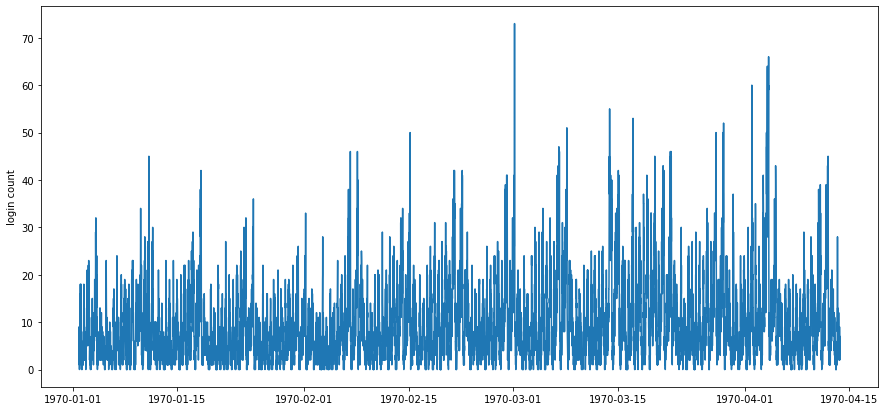

In [6]:
# Draw graph showing demand per 15 min time interval

plt.figure(figsize=(15,7))
plt.plot(login_df_15)
plt.ylabel('login count')

It looks like the demand rised in a constant period. The demand may increase on the weekends. However, things are not clear with a time interval of 15 min.

#### Login time by day

In [7]:
# Aggregate login counts based on days

daily = login_df.resample('D').sum()
fridays = login_df.resample('W-FRI').sum()
saturdays = login_df.resample('W-SAT').sum()
sundays = login_df.resample('W-SUN').sum()

Text(0, 0.5, 'login count')

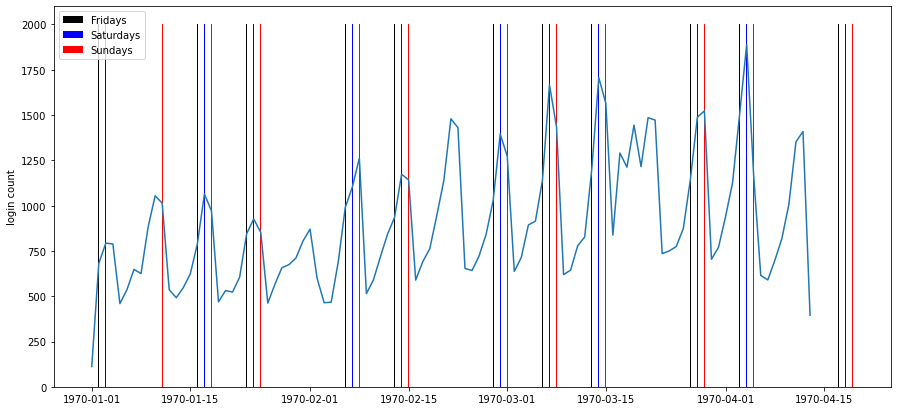

In [8]:
# Draw graph showing daily demand

plt.figure(figsize=(15,7))
plt.plot(daily)
plt.bar(fridays.index, 2000, label = "Fridays", width = 0.1, color='k')
plt.bar(saturdays.index, 2000, label = "Saturdays", width = 0.1, color='b')
plt.bar(sundays.index, 2000, label = "Sundays", width = 0.1, color='r')
plt.legend(loc='upper left')
plt.ylabel('login count')

It is clear from the graph that demand rised on the weekends. Saturday had the highest demand. 

#### Login time by hour

In [9]:
# Aggregate login counts based on hours
hourly = login_df.resample('H').sum()

# Create a separate day columns
hourly['day'] = hourly.index.dayofweek

# Keep only the hour information in the index
hourly.index = hourly.index.hour

In [10]:
# Create pivot table for average login count per each hour on each day
hourly_average = hourly.pivot_table(index='login_time', columns='day', values='count', aggfunc='mean')
hourly_average = hourly_average.rename(columns={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})
hourly_average = hourly_average.stack(level=['day']).reset_index()
hourly_average = hourly_average.rename(columns={0:'avg_count'})
hourly_average.head()

,login_time,day,avg_count
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000


<AxesSubplot:xlabel='login_time', ylabel='avg_count'>

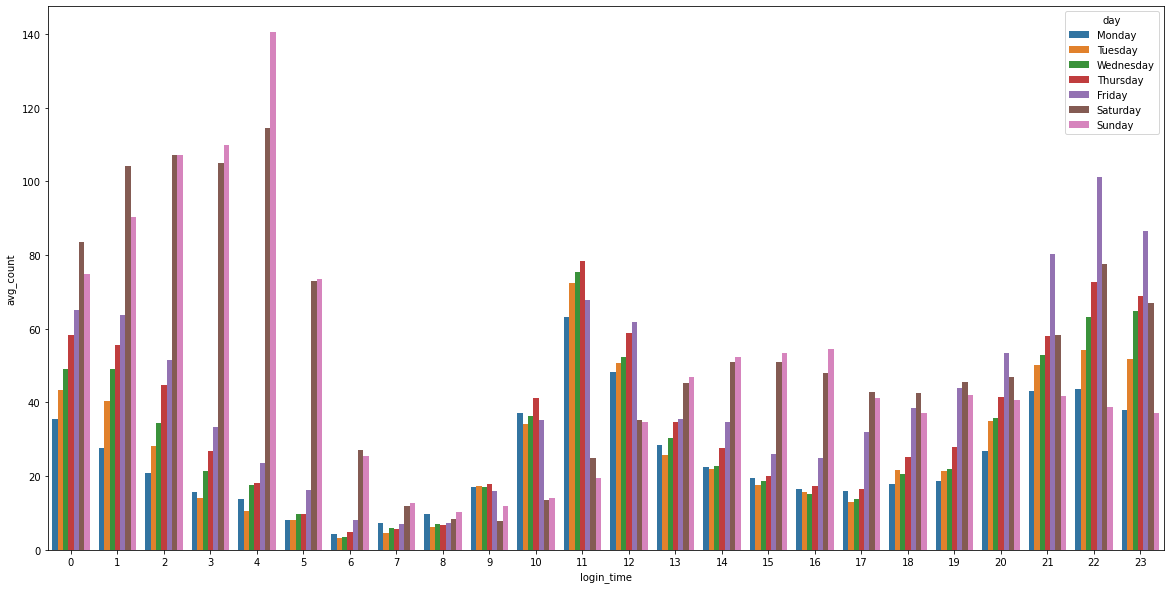

In [11]:
plt.figure(figsize=(20, 10))
sns.barplot(x='login_time', y='avg_count', hue='day', data=hourly_average)

The highest demand was in midnight hour from 0 to 5am, particularly on Saturday and Sunday. <br>
Demand rised on Friday from 21pm to 23pm. <br>
There was also high demand on weekday lunch time from 11am to 12pm. 

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

1. 
 - To measure of sucess of this experiment in encouraging driver partners to serve both cities, I will choose the number of times driver partners used the bridge to enter Gotham on weekdays at night and Metropolis on weekdays during the day. The data can be obtained by the city's records of car used the bridge. We can also collect data when the driver partners submit their reimbursement information.
 - In addtion, we can also measure if the number of booked rides increase in Gotham on weekdays at night and Metropolis on weekdays during the day.

2. 
 - We can implement the experiment by introducing a two week toll reimbursement for driver partners used the bridge to enter Gotham on weekdays at night and Metropolis on weekdays during the day. 
 - We can use two hypothesis tests to verify the significance of the observation:
 - Test #1 will test if there is a signicant increase in the average number of driver partners used the bridge to enter Gotham on weekdays at night during the two week toll reimbursement period.
 - Test #2 will test if there is a signicant increase in the average number of driver partners used the bridge to enter Metropolis on weekdays during the day during the two week toll reimbursement period.
 -  We can use z-test with a significant level of 5% for this test.
 - If p-value is below 5%, we can conclude the experiment has a positve result.

### Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).
Data description

In [12]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
df.shape

(50000, 12)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
# no user_id provided, delete duplicated rows

df = df.drop_duplicates()
df.shape

(49992, 12)

In [16]:
# Convert to datetime object

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [17]:
# the most recent last_trip_date, assume this is the date when the data extracted
# active users are users who took at least a trip between 2014-06-02 and 2014-07-01.

df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

#### Retention rate

In [18]:
# Retention rate

retention_rate = df[(df.last_trip_date > '2014-06-01')]['last_trip_date'].count() / df.signup_date.count()

print('Retention rate is {:.2f}%'.format(retention_rate * 100))

Retention rate is 36.63%


#### EDA

In [19]:
# Create user_status column

df['user_status'] = 'inactive'
df.loc[(df.last_trip_date > '2014-06-01'), 'user_status'] = 'active'
df.user_status.value_counts()

inactive    31682
active      18310
Name: user_status, dtype: int64

In [20]:
# Create 2 datasets for active and inactive users

df_active = df[df.user_status == 'active']
df_inactive = df[df.user_status == 'inactive']

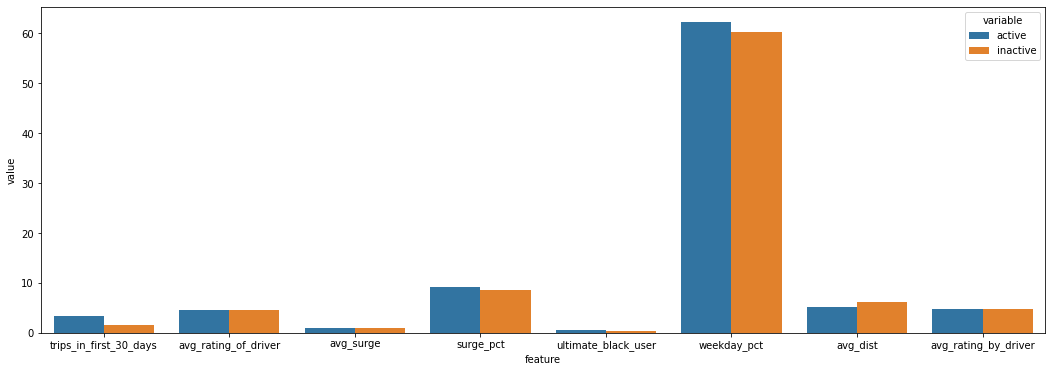

In [21]:
# examine average value in each numerical feature

summary = pd.concat([df_active.mean(), df_inactive.mean()], axis=1).reset_index()
summary.columns = ['feature', 'active', 'inactive']
summary = summary.melt(id_vars='feature')

plt.figure(figsize=(18, 6))
sns.barplot(x='feature', y='value', hue='variable', data=summary);

Active users has significant higher average value in 'trip_in_first_30_days' and 'ultimate_black_user'. <br>
Other features do not have any significant difference.

<AxesSubplot:xlabel='phone', ylabel='count'>

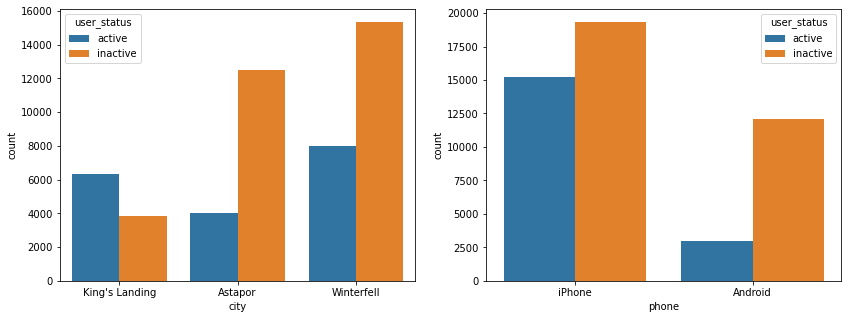

In [22]:
# examine categorical features

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='city', hue='user_status', data=df)

plt.subplot(1, 2, 2)
sns.countplot(x='phone', hue='user_status', data=df)

King's Landing users and iPhone users are more likely to be active. <br>
- More than half of King's Landing users are active.
- Nearly half of iPhone users are active. 

#### Predictive model

In [23]:
# fill missing value with mean values or most frequent value

df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(), inplace=True)
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(), inplace=True)
df.phone.fillna('iPhone', inplace=True)

df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
user_status               0
dtype: int64

In [24]:
# One Hot Encoding for categorical features

df = pd.get_dummies(df, columns = ['city', 'phone'])

In [25]:
# Create features and target

X = df.drop(columns=['user_status', 'signup_date', 'last_trip_date'])
y = df['user_status']
y = y.replace({'active':0, 'inactive':1})

In [26]:
# Create train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

In [27]:
# Random Forest model with default parameter

rf_clf = RandomForestClassifier(random_state=48)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print('Accuracy:', rf_clf.score(X_test, y_test))

cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
print('cv_scores: {}'.format(cv_scores))

Accuracy: 0.7606347513001733
cv_scores: [0.76053722 0.76239463 0.77068153 0.76796685 0.7602172 ]


In [28]:
# Initiate Random Forest Classifier
rf = RandomForestClassifier(max_features='auto', n_jobs=-1, random_state=19)

# Number of trees in random forest
n_estimators = [int(i) for i in np.linspace(100, 1000, 5)]

# Maximum depth of each tree
max_depth = [int(i) for i in np.linspace(10, 100, 10)]

# Create the param grid
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Apply GridSearchCV
rf_grid = RandomizedSearchCV(rf, param_grid, cv=5, n_jobs=-1, random_state=19)
rf_grid.fit(X_train, y_train)
              
print(rf_grid.best_params_) 
print('Accuracy:', rf_grid.best_score_)

cv_scores = cross_val_score(rf_grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print('cv_scores: {}'.format(cv_scores))

{'n_estimators': 1000, 'max_depth': 50}
Accuracy: 0.7641023351190375
cv_scores: [0.75767967 0.76225175 0.77182455 0.76753822 0.76121749]


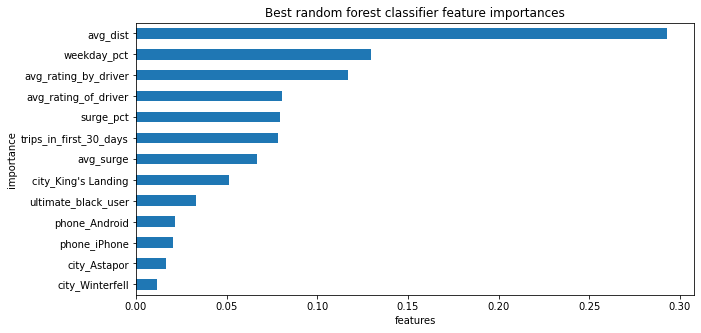

In [29]:
# Plot most important features to predict active users

plt.figure(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values()
rf_feat_imps.plot(kind='barh')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

The Random Forest Classifier Model performed 76% accuracy on the test data. <br>
The most important factor to predict an active user is the average distance in miles per trip taken in the first 30 days after signup.